In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [13]:
%matplotlib inline

import pandas as pd
from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from loading import load_session_data
from target import get_spike_counts
from statsmodels.formula.api import ols, glm
from sklearn.model_selection import train_test_split
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable
np.set_printoptions(suppress=True)

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
# all processed for 009266
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"
animal = '009266'
sessions = os.listdir(os.path.join(dst_path, animal))
sessions.sort()
sessions.remove('009266_hippoSIT_2023-05-04_09-11-06')
sessions.remove('009266_hippoSIT_2023-05-22_21-54-39')
len(sessions)

18

In [6]:
def unit_response_matrix(session, area, win_l, win_r):
    animal   = session.split('_')[0]
    meta_file  = os.path.join(dst_path, animal, session, 'meta.h5')
    units_file = os.path.join(dst_path, animal, session, 'units.h5')

    with h5py.File(meta_file, 'r') as f:
        sound_events = np.array(f['processed']['sound_events'])
        tgt_mx       = np.array(f['processed']['target_matrix'])
        tl           = np.array(f['processed']['timeline'])

    single_units, spike_times = {}, {}
    with h5py.File(units_file, 'r') as f:
        unit_names = [x for x in f]
    with h5py.File(units_file, 'r') as f:
        for unit_name in unit_names:
            spike_times[unit_name]  = np.array(f[unit_name][H5NAMES.spike_times['name']])
            single_units[unit_name] = np.array(f[unit_name][H5NAMES.inst_rate['name']])

    if area == 'A1':
        sel_units = [unit for unit in unit_names if int(unit[0]) < 3]
    elif area == 'PPC':
        sel_units = [unit for unit in unit_names if int(unit[0]) > 2]
    else:
        sel_units = unit_names  # all units

    unit_act_matrix = np.zeros([len(sound_events), len(sel_units)])
    for i, event in enumerate(sound_events):
        t_l = event[0] + win_l
        t_r = event[0] + win_r
        for j, unit_name in enumerate(sel_units):
            spks = spike_times[unit_name]
            unit_act_matrix[i, j] = len(spks[(spks > t_l) & (spks < t_r)])

    # z-score - should we?
    #unit_act_matrix = unit_act_matrix.T
    #for i, unit_data in enumerate(unit_act_matrix):
    #    unit_act_matrix[i] = stats.zscore(unit_data)
    return unit_act_matrix

In [12]:
area = 'A1'
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"
selected = sessions[:]
titles = ['P1', 'N1', 'P2', 'P3']
periods = [(0.01, 0.03), (0.03, 0.075), (0.075, 0.1), (0.1, 0.2)]

corr_mx = np.zeros((len(selected), len(periods), len(periods)))
for i, session in enumerate(selected):
    animal   = session.split('_')[0]
    meta_file  = os.path.join(dst_path, animal, session, 'meta.h5')
    units_file = os.path.join(dst_path, animal, session, 'units.h5')

    with h5py.File(meta_file, 'r') as f:
        sound_events = np.array(f['processed']['sound_events'])
        tgt_mx       = np.array(f['processed']['target_matrix'])
    
    # take BGR only!!
    idxs = np.where(sound_events[:, 1] == 1)[0]
                
    pop_mx = np.zeros((len(periods), len(sound_events)))
    for j, window in enumerate(periods):
        pop_mx[j] = unit_response_matrix(session, area, window[0], window[1]).sum(axis=1)

        for ii, metric1 in enumerate(titles):
            for jj, metric2 in enumerate(titles):
                m1 = pop_mx[ii]
                m2 = pop_mx[jj]
                corr_mx[i, ii, jj] = stats.pearsonr(m1[idxs], m2[idxs])[0]
    print(session)


009266_hippoSIT_2023-04-17_17-04-17
009266_hippoSIT_2023-04-18_10-10-37
009266_hippoSIT_2023-04-18_17-03-10
009266_hippoSIT_2023-04-19_10-33-51
009266_hippoSIT_2023-04-20_08-57-39
009266_hippoSIT_2023-04-20_15-24-14
009266_hippoSIT_2023-04-21_08-43-00
009266_hippoSIT_2023-04-21_13-12-31
009266_hippoSIT_2023-04-24_10-08-11
009266_hippoSIT_2023-04-24_16-56-55
009266_hippoSIT_2023-04-26_08-20-17
009266_hippoSIT_2023-05-02_12-22-14
009266_hippoSIT_2023-05-04_19-47-15
009266_hippoSIT_2023-05-22_09-27-22
009266_hippoSIT_2023-05-23_09-18-05
009266_hippoSIT_2023-05-25_15-55-57
009266_hippoSIT_2023-06-14_08-21-23
009266_hippoSIT_2023-06-19_08-58-35


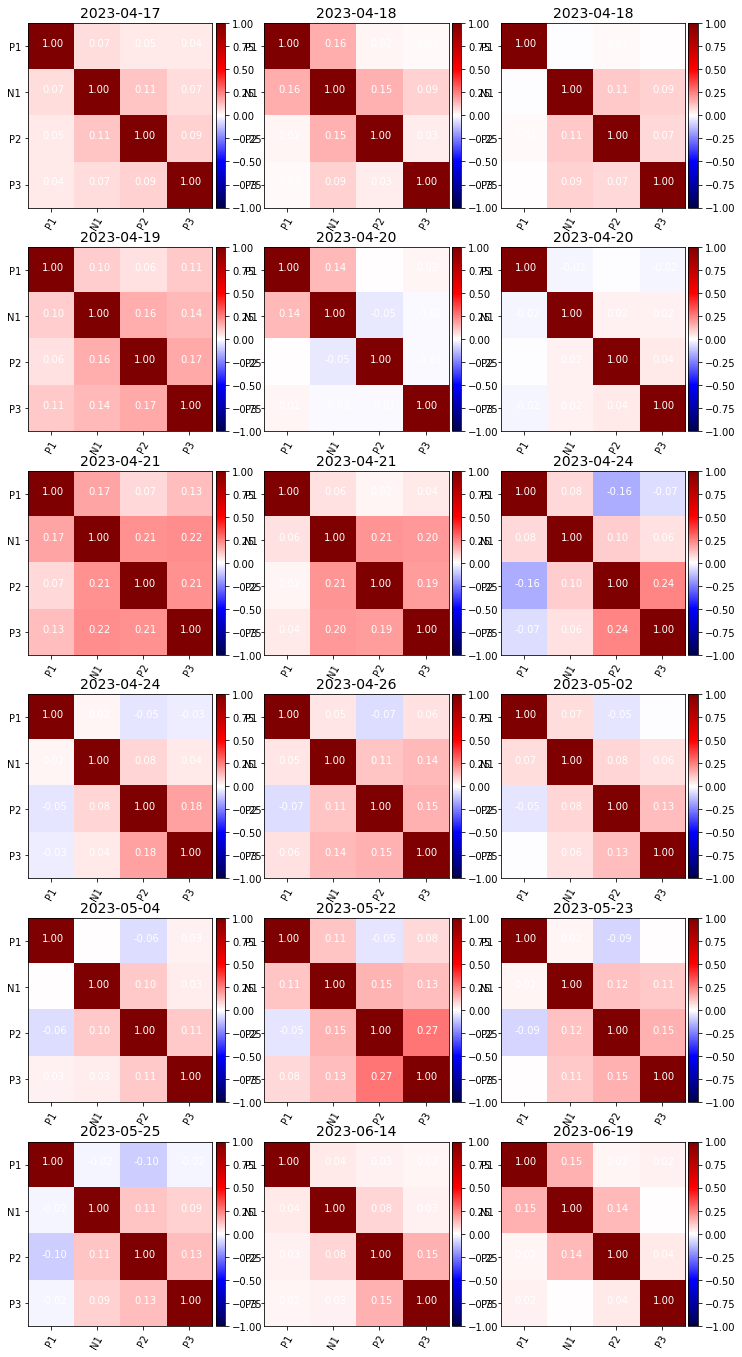

In [14]:
cols = 3
rows = int(np.ceil(len(selected)/cols))

fig = plt.figure(figsize=(12, 4*rows))
for ii, session in enumerate(selected):
    session_id = sessions.index(session)
    corr_pearson = corr_mx[session_id]

    ax = fig.add_subplot(rows, cols, ii+1)
    im = ax.imshow(corr_pearson, cmap='seismic', vmin=-1)
    ax.set_xticks(range(corr_pearson.shape[1]))
    ax.set_xticklabels(titles, rotation=60)
    ax.set_yticks(range(corr_pearson.shape[0]))
    _ = ax.set_yticklabels(titles)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title('%s' % session[-19:-9], fontsize=14)
    for p in range(corr_pearson.shape[0]):
        for q in range(corr_pearson.shape[1]):
            ax.text(p - 0.2, q, '%.2f' % corr_pearson[p, q], color='white')